In [128]:
import cv2
import numpy as np
from scipy.linalg import svd
import matplotlib.pyplot as plt
import math
import random
import sys
	
# path to input images are specified and
# images are loaded with imread command
img = cv2.imread('../images/Section-1/calib-object.jpg')
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


[[-0.6203364626880112, 0.06010218344486556, 0.23333718331075864, 1548.1196645374482], [-0.13748789220937835, 0.6638665572644411, -0.1364331555405412, 1610.4932310749155], [-0.00011609872764862705, 3.832496433655118e-05, -0.00012012200382155618, 1.0]]
8.548798527419425


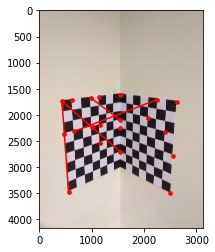

In [129]:
#       ~~~~~DFT~~~~~
n=20
u=280

imgx=[[433,1743],[614,1709],[485,2373],[1160,2531],[1548,2261],[1548,2711],[2246,1698],[2083,2064],[2404,2334],[2544,2784],[2511,3499],[665,2317],[991,1664],[1137,1659],[997,2227],[1160,2188],[1548,1614],[1548,2103],[2623,1760],[552,3465]]
wldx=[[7*u,0,0],[6*u,0,0],[7*u,3*u,0],[3*u,5*u,0],[0,4*u,0],[0,7*u,0],[0,0,5*u],[0,2*u,4*u],[0,3*u,6*u],[0,5*u,7*u],[0,9*u,7*u],[6*u,3*u,0],[4*u,0,0],[3*u,0,0],[4*u,3*u,0],[3*u,3*u,0],[0,0,0],[0,3*u,0],[0,0,7*u],[7*u,9*u,0]]
'''
imgx = [[427,1722],[631,1903],[820,2071],[991,2221],[1146,2356],[1287,2480],[1418,2595],[1293,2800],[1167,3016],[1020,2916],[2245,1685],[2076,1857],[2226,2082],[1918,2191],[1790,1983],[1663,1783],[1913,2364],[1781,2321],[1659,2441],[1780,2488]]
wldx = [[7,0,0],[6,1,0],[5,2,0],[4,3,0],[3,4,0],[2,5,0],[1,6,0],[2,7,0],[3,8,0],[4,7,0],[0,0,5],[0,1,4],[0,2,5],[0,3,3],[0,2,2],[0,1,1],[0,4,3],[0,4,2],[0,5,1],[0,5,2]]
'''
def projection(n,imgx,wldx):
    X=[[0]*4]*n
    for i in range(n):
        X[i]=[wldx[i][0], wldx[i][1], wldx[i][2], 1]
    wldx=X
    wldx=np.array(wldx)
    imgx=np.array(imgx)
    
    A =  np.zeros((2*n,12))
    for i in range(n):
        A[i*2,0:4] = -1 * wldx[i,:]
        A[i*2,8:12] = imgx[i,0]*wldx[i,:]
        A[i*2+1,4:8] = -1 * wldx[i,:]
        A[i*2+1,8:12] = imgx[i,1]*wldx[i,:]
    
    U, D, V = np.linalg.svd(A)
    P = V[11,:]
    P = (np.reshape(P,(3,4)))
    ### P is the projection matrix
    if n==6:
        return P
    P = P/P[2,3]
    P=P.tolist()
    return P
P=projection(n,imgx,wldx)
print(P)

def r_error(P,n,imgx,wldx):
    X=[[0]*4]*n
    for i in range(n):
        X[i]=[wldx[i][0], wldx[i][1], wldx[i][2], 1]
    #print(X)
    wldx=np.array(wldx)
    e=0
    for i in range(n):
        projected_points = np.dot(P,X[i])
        projected_points = projected_points/projected_points[2]
        #print(projected_points)
        e += np.square(projected_points[0] - imgx[i][0]) + np.square(projected_points[1] - imgx[i][1])
    rerror=math.sqrt(e/n)
    return rerror

rerror=r_error(P,n,imgx,wldx)

print(rerror)
t=[[P[0][0],P[0][1],P[0][2]],[P[1][0],P[1][1],P[1][2]],[P[2][0],P[2][1],P[2][2]]]
temp = np.linalg.inv(t)
R,K = np.linalg.qr(temp)
R = np.linalg.inv(R)
K = np.linalg.inv(K)
K = K/K[2,2]
t0=[P[0][3],P[1][3],P[2][3]]
T = -1*np.matmul(temp,t0)
'''
print(R)
print(K)
print(T)
'''

def plot_wireframe(projections, image):
    '''
    projections: n_samples X 2 ((height * width) X 2D point coordinate)
    image: on which wireframe has to be plotted
    '''
    # Plotting image points on the image
    plt.scatter(projections[:, 0], projections[:, 1], color='r', s=13, lw=1)

    # This is plotting vertical lines
    # We are finding two points across which we want to join a line. For this we are finding the nth and n+6th point for every line
    # This can be changes with you use case
    for (u, v) in zip(range(0, n, 6), range(5, n, 6)):
        plt.plot([projections[u, 0], projections[v, 0]], [projections[u, 1], projections[v, 1]], color='r')

    # Here the points are plotting horizontal lines
    for (u, v) in zip(range(6), range(n-1, n)):
        plt.plot([projections[u, 0], projections[v, 0]], [projections[u, 1], projections[v, 1]], color='r')
    
    plt.imshow(image)
X=[[0]*4]*n
for i in range(n):
    X[i]=[wldx[i][0], wldx[i][1], wldx[i][2], 1]
#print(X)
wldx=np.array(wldx)
points=[[0]*3]*n
for i in range(n):
    points[i] = np.matmul(P,X[i])
    points[i]=points[i]/points[i][2]
points=np.array(points)   
#print(points)

plot_wireframe(points,img1)


In [130]:
#        ~~~~RANSAC~~~~
N = 2000
k=7

###add more image ND WORLD POINTS AND CHANGE THE n VALUE...K NEEDS TO BE MINIMUM 6

I_pts = np.zeros((k,2))
W_pts = np.zeros((k,3))
errorbest = 100
pbest = []
for i in range(N):
    p = 0
    q = 0
    l  = random.sample(range(n),k)
    for j in range(n):
        if j in l:
            I_pts[q][:] = imgx[j][:]
            W_pts[q][:] = wldx[j][:]
            q = q + 1
    P = projection(q,I_pts, W_pts)
    cerror = r_error(P,q,I_pts,W_pts)
    if (cerror < errorbest):
        pbest =  P.copy()
        errorbest = cerror
print(pbest)
print(errorbest)

/var/folders/30/znbr2wqs7b955ybvxgp7s7_r0000gn/T/ipykernel_54506/690909717.py:32: RuntimeWarning: divide by zero encountered in true_divide
  P = P/P[2,3]
/var/folders/30/znbr2wqs7b955ybvxgp7s7_r0000gn/T/ipykernel_54506/690909717.py:32: RuntimeWarning: invalid value encountered in true_divide
  P = P/P[2,3]


[[-0.6060791894878497, 0.05116693902812021, 0.2472642449446179, 1547.5001796561976], [-0.09761362585777568, 0.6529224654118408, -0.12700963652736255, 1612.5262237463237], [-0.00010074639654418132, 3.2728318742079025e-05, -0.00011493055892356489, 1.0]]
0.13727346602437657


In [131]:
#      ~~~~~TRIANGULATION~~~~~~
#finding DLT of cube-01
imgx1=[[1955,1788],[1646,1642],[2190,1306],[1898,1226],[2377,1976],[2519,1740],[2320,1586]]
wldx=[[1,0,1],[2,0,1],[1,1,0],[2,1,0],[1,2,0],[0,1,1],[0,0,0]]
P1=projection(7,imgx1,wldx)
imgx2=[[1508,1678],[1358,1561],[1817,1256],[1655,1168],[2117,1184],[2040,1711],[1695,1488]]
P2=projection(7,imgx2,wldx)
P2=np.array(P2)
P1=np.array(P1)
imgx1=np.array(imgx1)
imgx2=np.array(imgx2)
def triangulate(P1, P2, pts1, pts2):
    num_points = pts1.shape[0]
    pts_3d = np.zeros((4, num_points))
    
    for i in range(num_points):
        x1 = pts1[i, 0]
        y1 = pts1[i, 1]
        x2 = pts2[i, 0]
        y2 = pts2[i, 1]
        
        A = np.array([x1*P1[2,:] - P1[0,:], y1*P1[2,:] - P1[1,:], x2*P2[2,:] - P2[0,:], y2*P2[2,:] - P2[1,:]])
        _, _, vt = np.linalg.svd(A)
        pts_3d[:, i] = vt[-1, :] / vt[-1, -1]
    return pts_3d
cpoint=triangulate(P1,P2,imgx1,imgx2)
pt=np.zeros(4)
pt[0]=np.sum(cpoint[0][:])/7
pt[1]=np.sum(cpoint[1][:])/7
pt[2]=np.sum(cpoint[2][:])/7
pt[3]=np.sum(cpoint[3][:])/7
print(pt)

[0.99934882 0.71292397 0.42740885 1.        ]


In [132]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img1 = cv2.imread('../images/Section-4/building/1.jpg')
img2 = cv2.imread('../images/Section-4/building/2.jpg')
img3 = cv2.imread('../images/Section-4/building/3.jpg')

def image_stitching(img2,img1):
    ratio=0.85
    min_match=10
    sift=cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    #matching features
    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(des1, des2, k=2)
    gpoints = []
    gmatches=[]
    for m1, m2 in matches:
        if m1.distance < ratio * m2.distance:
            gpoints.append((m1.trainIdx, m1.queryIdx))
            gmatches.append([m1])
    img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, gmatches, None, flags=2)
        #cv2.imwrite('matching.jpg', img3)
        #finding homography matrix
    image1_kp = np.float32([kp1[i].pt for (_, i) in gpoints]).reshape(-1,1,2)
    image2_kp = np.float32([kp2[i].pt for (i, _) in gpoints]).reshape(-1,1,2)
    H, status = cv2.findHomography(image1_kp, image2_kp, cv2.RANSAC,5.0)
    #wrapping the image
    image2_kp = cv2.warpPerspective(img1, H, (img2.shape[1]+img1.shape[1],img2.shape[0]))

    #cv2.imwrite('flkiho.jpg', image2_kp)
    img2 = cv2.resize(img2, (img1.shape[1],img2.shape[0]))
    #stitching
    image2_kp[0:img1.shape[0], 0:img1.shape[1]] = img2
    return image2_kp
#to resize the images based on width
def remove_space(fr):
    for ar_x in range(fr.shape[1]-1,0,-1):
        res = np.all(fr[:,ar_x] == (0,0,0))  
        if res:
            fr = fr[:,0:(ar_x)]
            # print('black', ar_x)
        else:
            #print('break at :', ar_x ,' column')
            break
    return fr
#buliding
fr=image_stitching(img1,img2)
fr=remove_space(fr)
cv2.imwrite('../Results/Q-4/buildings/f-right.jpg',fr)
fl=image_stitching(img2,img3)
fl=remove_space(fl)
cv2.imwrite('../Results/Q-4/buildings/f-left.jpg',fl)
f=image_stitching(fr,fl)
f=remove_space(f)
cv2.imwrite('../Results/Q-4/buildings/final.jpg',f)
#flower
img1 = cv2.imread('../images/Section-4/flower/1.jpg')
img2 = cv2.imread('../images/Section-4/flower/2.jpg')
img3 = cv2.imread('../images/Section-4/flower/3.jpg')
img4 = cv2.imread('../images/Section-4/flower/3.jpg')
fr=image_stitching(img1,img2)
fr=remove_space(fr)
cv2.imwrite('../Results/Q-4/flower/f-right.jpg',fr)
fl=image_stitching(img4,img3)
fl=remove_space(fl)
cv2.imwrite('../Results/Q-4/flower/f-left.jpg',fl)
f=image_stitching(fr,fl)
f=remove_space(f)
cv2.imwrite('../Results/Q-4/flower/final.jpg',f)
#school
img1 = cv2.imread('../images/Section-4/school/1.jpg')
img2 = cv2.imread('../images/Section-4/school/2.jpg')
f=image_stitching(img1,img2)
f=remove_space(f)
cv2.imwrite('../Results/Q-4/school_final.jpg',f)


True